In [30]:
import nest_asyncio
nest_asyncio.apply()

from hddCRP.modelBuilder import cdCRP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statannotations.Annotator import Annotator

import os

In [31]:
session_numbers = [1]; # index by 1

overwrite_existing_results = False
results_directory = "Results/individualFit/"

if(not os.path.exists(results_directory)):
    os.makedirs(results_directory)

data_filename = 'data/Data_turns_all_by_session.pkl';
with open(data_filename, 'rb') as data_file:
    data = pickle.load(data_file)

subjects = list(data["data"].keys())
subjects.sort()
print("subjects = " + str(subjects))

action_labels = [0,1,2]

subjects = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'D1', 'D2', 'E1', 'E2', 'F1', 'F2', 'G1', 'G2', 'H1', 'I1', 'I2', 'J1', 'J2']


In [32]:
start_session = np.min(session_numbers)
end_session = np.max(session_numbers)
fit_file = f"{results_directory}/fits_session_{start_session}"
fit_summary_file = f"{results_directory}/fit_summary_session_{start_session}"
if(end_session != start_session):
    fit_file += f"_to_{start_session}"
    fit_summary_file  += f"_to_{start_session}"
fit_file += f".pkl"
fit_summary_file += f".pkl"

if(not os.path.isfile(fit_file) or overwrite_existing_results):
    data_fits = pd.DataFrame()
    data_fit_metrics = pd.DataFrame()
    for subject_index, subject in enumerate(subjects):
        print(f"subject {subject} ")
        sequences_0 = data["data"][subject]["data"]; # turns in each session
        session_types_0 = data["data"][subject]["task"] # which maze

        ii = list(np.where(np.array(session_types_0)=='C')[0][np.array(session_numbers)-1])
        sequences = [sequences_0[xx] for xx in ii]
        session_types = [session_types_0[xx] for xx in ii]

        stan_seed = (subject_index+1) * 1000 + start_session

        model = cdCRP(sequences, session_labels=session_types, subject_labels=subject, possible_observations=action_labels);
        model.build(random_seed=stan_seed);
        model.fit_model()

        map_fit = model.get_map()
        fit_df = model.fit.to_frame()
        fit_df["subject"] = subject
        fit_df["start_session_C"] = start_session
        fit_df["end_session_C"] = end_session
        summary_df = model.fit_summary()
        summary_df["subject"] = subject
        summary_df["MAP"] = pd.Series(map_fit)
        summary_df["start_session_C"] = start_session
        summary_df["end_session_C"] = end_session

        data_fit_metrics = pd.concat([data_fit_metrics,summary_df], copy=False)
        data_fits = pd.concat([data_fits,fit_df], copy=False)

    data_fits.to_pickle(fit_file)
    data_fit_metrics.to_pickle(fit_summary_file)
else:
    print("fit file found")



fit file found


<Figure size 1000x600 with 0 Axes>

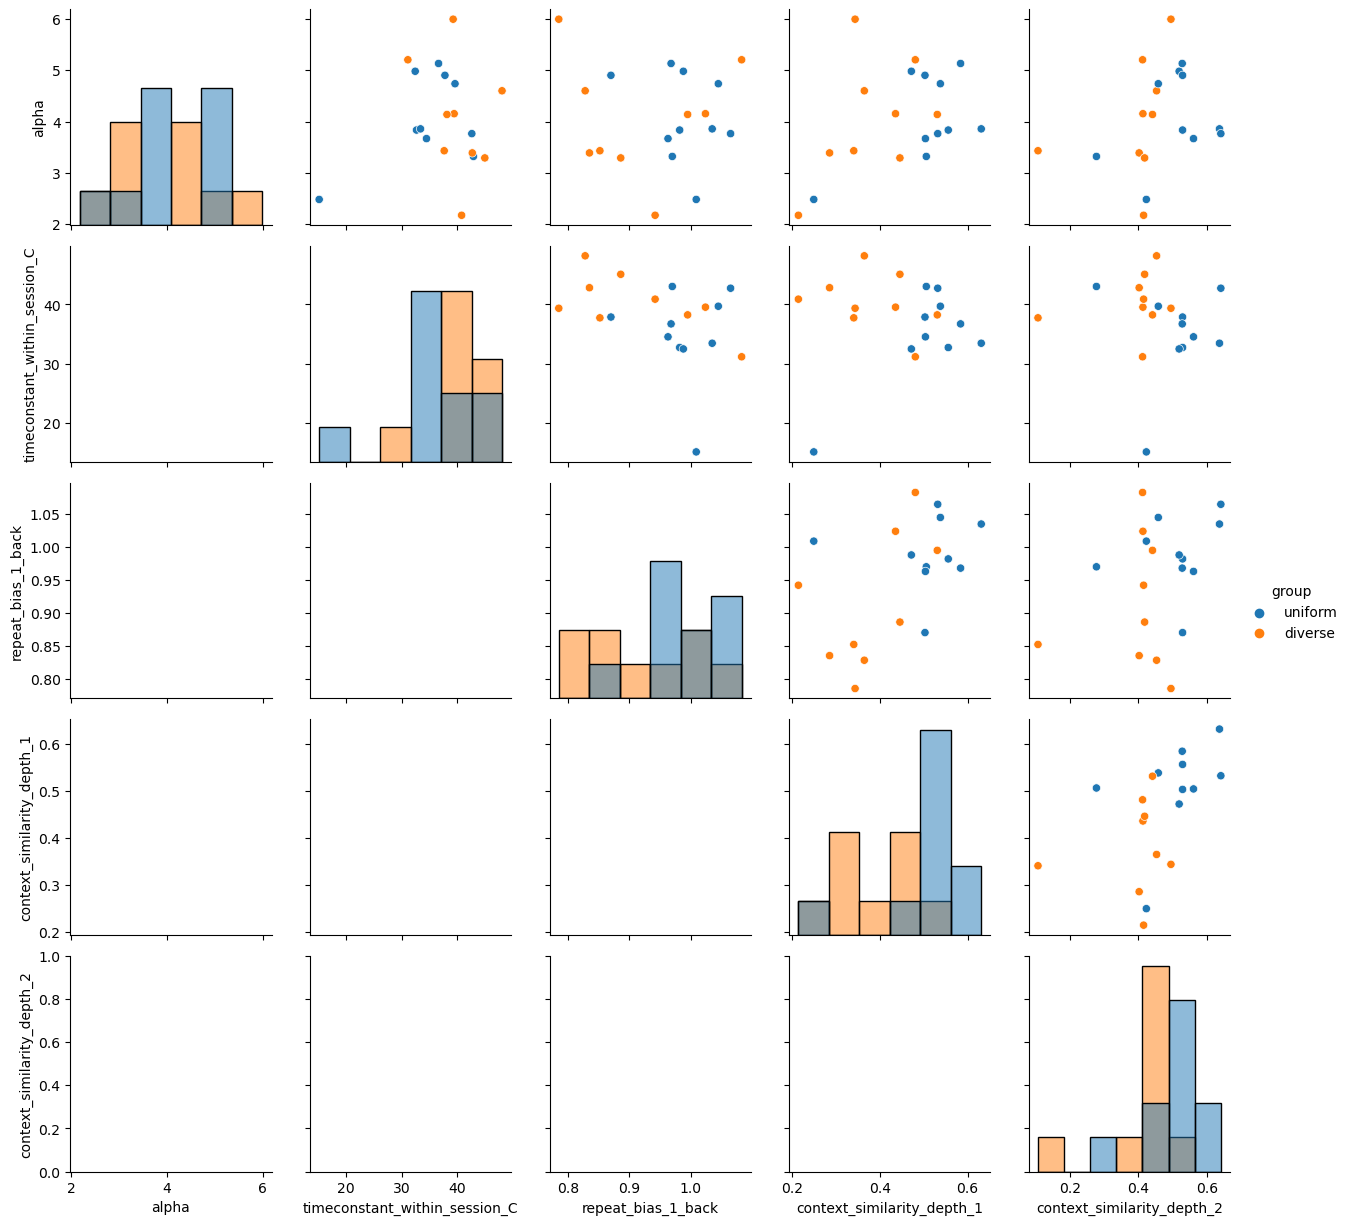

In [33]:
fit_summary = pd.read_pickle(fit_summary_file)
group_names = np.array(["uniform", "diverse"])

mapping = {}
for jj in range(2):
    for ii in data["group_definition"][group_names[jj]]:
        mapping[ii] = group_names[jj]
fit_summary["group"] = fit_summary["subject"].map(mapping)

params = list(fit_summary.index.unique())

fit_summary.index.name = 'parameter'
fit_summary = fit_summary.reset_index()

formatted_fit = pd.DataFrame()
for ii in params:
    formatted_fit[ii] = fit_summary[["median","subject"]][fit_summary["parameter"] == ii].set_index("subject")
formatted_fit = formatted_fit.reset_index()
formatted_fit["group"] = formatted_fit["subject"].map(mapping)
formatted_fit = formatted_fit.set_index("subject")

#     print(fit_summary["median"][fit_summary["parameter"] == ii])
plt.figure(figsize=(10,6))
g = sns.PairGrid(formatted_fit, hue="group")
g.map_upper(sns.scatterplot)
g.map_diag(sns.histplot)
g.add_legend()
# fit_summary[["median","subject"]].set_index("subject")

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

timeconstant_within_session_C_uniform vs. timeconstant_within_session_C_diverse: Mann-Whitney-Wilcoxon test two-sided, P_val:1.113e-01 U_stat=2.500e+01


Text(0.5, 14.581597222222216, '')

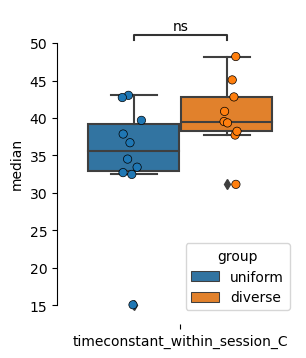

In [34]:

grps = [["timeconstant_within_session_C"], ["alpha"], ["repeat_bias_1_back", "context_similarity_depth_1", "context_similarity_depth_2"]]
ii = 0
plt.figure(figsize=(len(grps[ii])*3,4))
fit_summary2 = formatted_fit[grps[ii] + ["group"]]
fit_summary2 = fit_summary2.melt("group").rename(columns={"variable" : "parameter", "value" : "median"})
ax = sns.boxplot(x="parameter", y="median", order=grps[ii], hue_order=["uniform", "diverse"],
            hue="group",
            data=fit_summary2)

pairs = [((xx, "uniform"), (xx, "diverse")) for xx in grps[ii]]
annot = Annotator(ax, pairs=pairs, data=fit_summary2, x="parameter", y="median", order=grps[ii], hue="group", hue_order=["uniform", "diverse"])
#Annotator.new_plot(ax=ax, pairs=pairs, data=fit_summary2, x="parameter", y="median", order=grps[ii], hue="group", hue_order=["uniform", "diverse"])
annot.configure(test='Mann-Whitney', verbose=2, text_format='simple')
annot.apply_test()
annot.annotate()

sns.stripplot(fit_summary2, x="parameter", y="median", hue="group", size=6, 
            dodge=True, alpha=1, legend=False, edgecolor=[0,0,0], linewidth=0.5)
sns.despine(offset=5, trim=True)
plt.xlabel(None)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

alpha_uniform vs. alpha_diverse: Mann-Whitney-Wilcoxon test two-sided, P_val:9.025e-01 U_stat=4.700e+01


Text(0.5, 14.722222222222216, '')

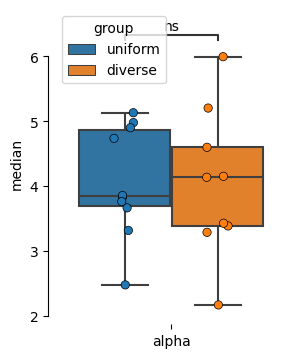

In [35]:
ii = 1
plt.figure(figsize=(len(grps[ii])*3,4))
fit_summary2 = formatted_fit[grps[ii] + ["group"]]
fit_summary2 = fit_summary2.melt("group").rename(columns={"variable" : "parameter", "value" : "median"})
ax = sns.boxplot(x="parameter", y="median", order=grps[ii], hue_order=["uniform", "diverse"],
            hue="group",
            data=fit_summary2)

pairs = [((xx, "uniform"), (xx, "diverse")) for xx in grps[ii]]
annot = Annotator(ax, pairs=pairs, data=fit_summary2, x="parameter", y="median", order=grps[ii], hue="group", hue_order=["uniform", "diverse"])
#Annotator.new_plot(ax=ax, pairs=pairs, data=fit_summary2, x="parameter", y="median", order=grps[ii], hue="group", hue_order=["uniform", "diverse"])
annot.configure(test='Mann-Whitney', verbose=2, text_format='simple')

annot.apply_test()
annot.annotate()


sns.stripplot(fit_summary2, x="parameter", y="median", hue="group", size=6, 
            dodge=True, alpha=1, legend=False, edgecolor=[0,0,0], linewidth=0.5)
sns.despine(offset=5, trim=True)
plt.xlabel(None)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

context_similarity_depth_1_uniform vs. context_similarity_depth_1_diverse: Mann-Whitney-Wilcoxon test two-sided, P_val:1.011e-02 U_stat=7.700e+01
repeat_bias_1_back_uniform vs. repeat_bias_1_back_diverse: Mann-Whitney-Wilcoxon test two-sided, P_val:1.113e-01 U_stat=6.500e+01
context_similarity_depth_2_uniform vs. context_similarity_depth_2_diverse: Mann-Whitney-Wilcoxon test two-sided, P_val:7.936e-03 U_stat=7.800e+01


Text(0.5, 14.581597222222216, '')

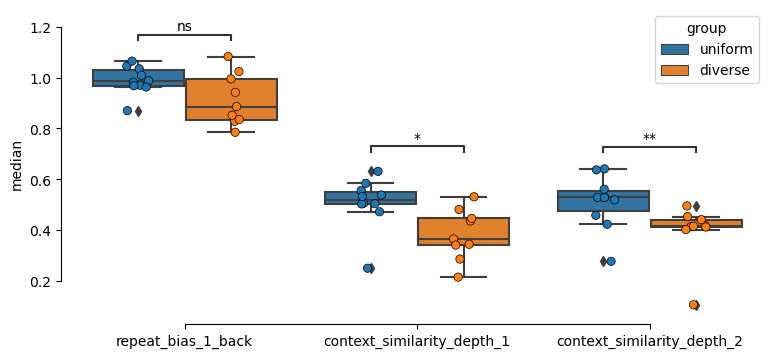

In [37]:
ii = 2
plt.figure(figsize=(len(grps[ii])*3,4))
fit_summary2 = formatted_fit[grps[ii] + ["group"]]
fit_summary2 = fit_summary2.melt("group").rename(columns={"variable" : "parameter", "value" : "median"})
ax = sns.boxplot(x="parameter", y="median", order=grps[ii], hue_order=["uniform", "diverse"],
            hue="group",
            data=fit_summary2)

pairs = [((xx, "uniform"), (xx, "diverse")) for xx in grps[ii]]
annot = Annotator(ax, pairs=pairs, data=fit_summary2, x="parameter", y="median", order=grps[ii], hue="group", hue_order=["uniform", "diverse"])
#Annotator.new_plot(ax=ax, pairs=pairs, data=fit_summary2, x="parameter", y="median", order=grps[ii], hue="group", hue_order=["uniform", "diverse"])
annot.configure(test='Mann-Whitney', verbose=2, text_format='simple')
annot.apply_test()
annot.annotate()
sns.stripplot(fit_summary2, x="parameter", y="median", hue="group", size=6, 
            dodge=True, alpha=1, legend=False, edgecolor=[0,0,0], linewidth=0.5)
sns.despine(offset=5, trim=True)
plt.xlabel(None)